# Notebook magique with AutoML

TO DO:
- remove outliers: implement new fucntion + get right percentage
- test different numbers of topics and clusters 

See 
https://github.com/parklize/cikm2020-analyticup?fbclid=IwAR0Ti_pF7HrIO5ELFlvA1b2FEL_D68xlu_XdXeFxyARzBfY5U7a040klHTM

Import libraries

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List

import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

from verstack.stratified_continuous_split import scsplit

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from textblob import TextBlob  # pip install textblob-fr
from textblob_fr import PatternTagger, PatternAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Import dataset and split it into train and test sets

In [2]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")

# split data
X_train, X_test, y_train, y_test = scsplit(
    train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)

## Outliers

In [3]:
# remove outliers with quartile
def remove_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df




# 2% of outliers are removed for 3 variables. In total 5 to 6% of  data is removed

@Marian : on fait quoi de ce bout de code ?

q = raw_data_mod_2["UserFollowersCount"].quantile(0.98)

data_1 = raw_data_mod_2[raw_data_mod_2["UserFollowersCount"]<q]


q2 = data_1["UserFriendsCount"].quantile(0.98)

data_2 = data_1[data_1["UserFriendsCount"]<q2]


q3 = data_2["UserTweetCount"].quantile(0.98)

data_3 = data_2[data_2["UserTweetCount"]<q3]

data_3.info()



In [4]:
def feature_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df

    # mentions is always empty -> DROP Mention
    res_df = res_df.drop(['mention'], axis=1)

    # add a column to data which counts url
    res_df['url_count'] = res_df['urls'].str.count('http')
    # add columns to data which makes ratios
    res_df['followers_friends'] = res_df['followers_count'] / (res_df['friends_count'].apply(lambda x: x+1))
    
    return res_df

In [5]:

def time_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df
    res_df["hour"] = res_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).hour))
    res_df["day"] = res_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000)).weekday())
    res_df["week_in_month"] = res_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).day)//7)

    return res_df


In [6]:

def extract_topic(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df
    res_df['hashtags'] = res_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
    #join text and hashtags
    res_df['total_text'] = res_df['text'] + ' ' + res_df['hashtags']
    vectorizer = TfidfVectorizer(min_df=1, max_features=None, stop_words=stopwords.words('french'))
    vector = vectorizer.fit_transform(res_df['total_text'])
    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    svd.fit(vector)
    topic=svd.transform(vector)
    res_df['topic_1'] = topic[:,0]
    res_df['topic_2'] = topic[:,1]
    res_df['topic_3'] = topic[:,2]
    res_df['topic_4'] = topic[:,3]
    res_df['topic_5'] = topic[:,4]
    return res_df

In [7]:
def text_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    res_df = input_df
    # add columns related to sentiment analysis
    res_df['polarity'] = res_df['total_text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0])
    res_df['subjectivity'] = res_df['total_text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1])

    return res_df

In [8]:
def hashtags_engineering(input_df):
    res_df = input_df
    
    # add a column to data which gives number of hashtags
    res_df['hashtags_count'] = res_df['hashtags'].apply(lambda hashtags: len(hashtags.split(",")) if hashtags != "" else 0)
    
    return res_df

In [9]:
def extract_cluster(input_df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    res_df = input_df
    res_df['cluster'] = KMeans(n_clusters=100, random_state=0).fit_predict(res_df[columns].values)
    return res_df

## Scaler

In [10]:
def logtransformdrop(dataframe: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    for col in cols:
        dataframe[col] = dataframe[col].apply(lambda x: np.log10(int(x)+1))
    return dataframe

## Data processing

In [11]:
columns = ['TweetID', 'urls', 'timestamp', 'text', 'total_text', 'hashtags', 'followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'url_count', 'followers_friends',
       'hour', 'day','week_in_month', 'polarity', 'subjectivity', 'hashtags_count', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','cluster']
# contains all columns except retweets_count (the value to predict) and mentions (always empty)

In [12]:
remove_useless = ["urls", "timestamp", "TweetID", "text", "hashtags", "total_text"]

In [13]:
new_X_train = feature_engineering(X_train)
new_X_train = time_engineering(new_X_train)
new_X_train = extract_topic(new_X_train)
new_X_train = text_engineering(new_X_train)
new_X_train = hashtags_engineering(new_X_train)
new_X_train = extract_cluster(new_X_train,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_train = new_X_train.reindex(columns=columns)

In [14]:
new_X_train = new_X_train.drop(remove_useless, axis=1)

In [15]:
remove=['verified', 'url_count', 'week_in_month','day', 'topic_2', 'topic_3', 'topic_4', 'topic_5'] # 'polarity', 'subjectivity', 'hashtags_count', 

In [16]:
new_X_train = new_X_train.drop(remove, axis=1)
new_X_train.head()

,followers_count,friends_count,favorites_count,statuses_count,followers_friends,hour,polarity,subjectivity,hashtags_count,topic_1,cluster
122925,5,71,2,291,0.069444,14,-0.050000,5.000000e-02,2,0.099072,0
350303,337,395,0,9818,0.851010,11,0.000000,0.000000e+00,0,0.000960,41
2829,3465,5000,4,95902,0.692861,10,0.013333,5.333333e-01,0,0.038686,33
239060,1747,4994,0,100708,0.349750,20,0.000000,0.000000e+00,1,0.012473,33
107437,84,86,0,2357,0.965517,19,-0.166000,-5.551115e-18,0,0.040897,0


## Flaml

In [18]:
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 3600,  # total running time in seconds
    "metric": 'mae',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
    # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'regression',  # task type
    # [catboost, kneighbor, 'lgbm', 'xgboost', 'extra_tree',]
    'estimator_list': ['rf', 'xgb_limitdepth'],
    "seed": 7654321,    # random seed
}

automl.fit(new_X_train, y_train, **settings)
# Print the best model
print(automl.model.estimator)


[flaml.automl: 11-29 09:59:24] {2599} INFO - task = regression
[flaml.automl: 11-29 09:59:24] {2601} INFO - Data split method: uniform
[flaml.automl: 11-29 09:59:24] {2604} INFO - Evaluation method: holdout
[flaml.automl: 11-29 09:59:24] {2726} INFO - Minimizing error metric: mae
[flaml.automl: 11-29 09:59:24] {2870} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 11-29 09:59:24] {3166} INFO - iteration 0, current learner rf
[flaml.automl: 11-29 09:59:24] {3296} INFO - Estimated sufficient time budget=14782s. Estimated necessary time budget=54s.
[flaml.automl: 11-29 09:59:24] {3343} INFO -  at 0.6s,	estimator rf's best error=11.5127,	best estimator rf's best error=11.5127
[flaml.automl: 11-29 09:59:24] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-29 09:59:24] {3343} INFO -  at 0.7s,	estimator lgbm's best error=17.7997,	best estimator rf's best error=11.5127
[flaml.automl: 11-29 09:59:24] {3166

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=[],
             colsample_bylevel=0.9876392518281302, colsample_bynode=1,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.10345093113695748,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0,
             min_child_weight=1.051080893063133, missing=nan,
             monotone_constraints='()', n_estimators=25, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [45]:
#print(automl.model.estimator)
#print(automl.best_config_per_estimator)
print(dir(automl))
print()
print(automl.best_config_per_estimator)
print()
print(automl.model.get_params())
print()
print(automl.model.estimator.get_params())
print()
print(automl.model.estimator)

['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__version__', '__weakref__', '_active_estimators', '_auto_augment', '_best_estimator', '_best_iteration', '_check_feature_names', '_check_n_features', '_config_history', '_decide_eval_method', '_decide_split_type', '_df', '_early_stop', '_eci', '_ensemble', '_estimator_index', '_estimator_type', '_feature_names_in_', '_fullsize_reached', '_get_param_names', '_get_tags', '_hpo_method', '_iter_per_learner', '_iter_per_learner_fullsize', '_label_transformer', '_learner_selector', '_log_trial', '_log_type', '_max_iter', '_max_iter_per_learner', '_mem_thres', '_metric_constraints', '_min_sample_size', '_min_sample_size_inpu

Old result (Marian) : RandomForestRegressor(max_features=0.627831612990693, max_leaf_nodes=11554, n_estimators=16, n_jobs=-1)

New result (Antoine) : RandomForestRegressor(max_features=0.9685938144371158, max_leaf_nodes=2238, n_estimators=24, n_jobs=-1)


AutoML.fit(self, X_train, y_train, dataframe, label, metric, task, n_jobs, log_file_name, estimator_list, time_budget, max_iter, sample, ensemble, eval_method, log_type, model_history, split_ratio, n_splits, log_training_metric, mem_thres, pred_time_limit, train_time_limit, X_val, y_val, sample_weight_val, groups_val, groups, verbose, retrain_full, split_type, learner_selector, hpo_method, starting_points, seed, n_concurrent_trials, keep_search_state, preserve_checkpoint, early_stop, append_log, auto_augment, min_sample_size, use_ray, metric_constraints, custom_hp, cv_score_agg_func, skip_transform, fit_kwargs_by_estimator, **fit_kwargs)


xgboost, rf, lgbm, extra_tree

# Submission

In [49]:
# test on X_test
new_X_test = feature_engineering(X_test)
new_X_test = time_engineering(new_X_test)
new_X_test = extract_topic(new_X_test)
new_X_test = text_engineering(new_X_test)
new_X_test = hashtags_engineering(new_X_test)
new_X_test = extract_cluster(new_X_test,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_test = new_X_test.reindex(columns=columns)

In [50]:
new_X_test = new_X_test.drop(remove_useless, axis=1)
new_X_test = new_X_test.drop(remove, axis=1)
print(new_X_train.columns)
print(new_X_test.columns)

Index(['followers_count', 'friends_count', 'favorites_count', 'statuses_count',
       'followers_friends', 'hour', 'polarity', 'subjectivity',
       'hashtags_count', 'topic_1', 'cluster'],
      dtype='object')
Index(['followers_count', 'friends_count', 'favorites_count', 'statuses_count',
       'followers_friends', 'hour', 'polarity', 'subjectivity',
       'hashtags_count', 'topic_1', 'cluster'],
      dtype='object')


In [47]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor

model = RandomForestRegressor(max_features=0.9894656081824227, max_leaf_nodes=1396, n_estimators=6, n_jobs=-1, criterion='mae')
mse_model = RandomForestRegressor(max_features=0.8773890634249363, max_leaf_nodes=2133, n_estimators=23, n_jobs=-1)

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=[],
             colsample_bylevel=0.9876392518281302, colsample_bynode=1,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.10345093113695748,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0,
             min_child_weight=1.051080893063133, 
             monotone_constraints='()', n_estimators=25, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, 
             reg_alpha= 0.0400147579159508, reg_lambda= 1.4102515706547767, 
             sampling_method= 'uniform', scale_pos_weight= 1, subsample= 0.7946527720376892, 
             tree_method= 'exact', validate_parameters= 1, verbosity= 0, use_label_encoder= False)



In [51]:
mse_model.fit(new_X_train, y_train)
y_pred = mse_model.predict(new_X_test)
y_pred = [round(value) if value >= 0 else 0 for value in y_pred]

print(f"mse model : {mean_absolute_error(y_test, y_pred)}")

xgb_model.fit(new_X_train, y_train)
y_pred = xgb_model.predict(new_X_test)
y_pred = [round(value) if value >= 0 else 0 for value in y_pred]

print(f"xgb model : {mean_absolute_error(y_test, y_pred)}")

mse model : 6.612156397434811
xgb model : 6.522106393197164


In [ ]:
def write_predictions_to_file(file_name):
    with open(file_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["TweetID", "retweets_count"])
        for index, prediction in enumerate(y_pred):
            writer.writerow([str(eval_data['TweetID'].iloc[index]) , str(int(prediction))])



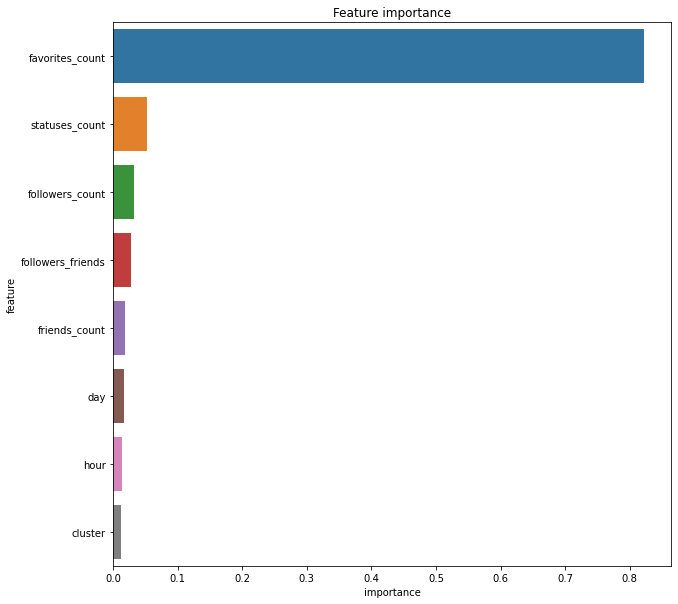

<AxesSubplot:>

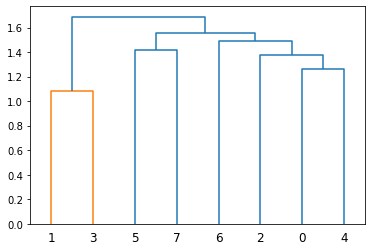

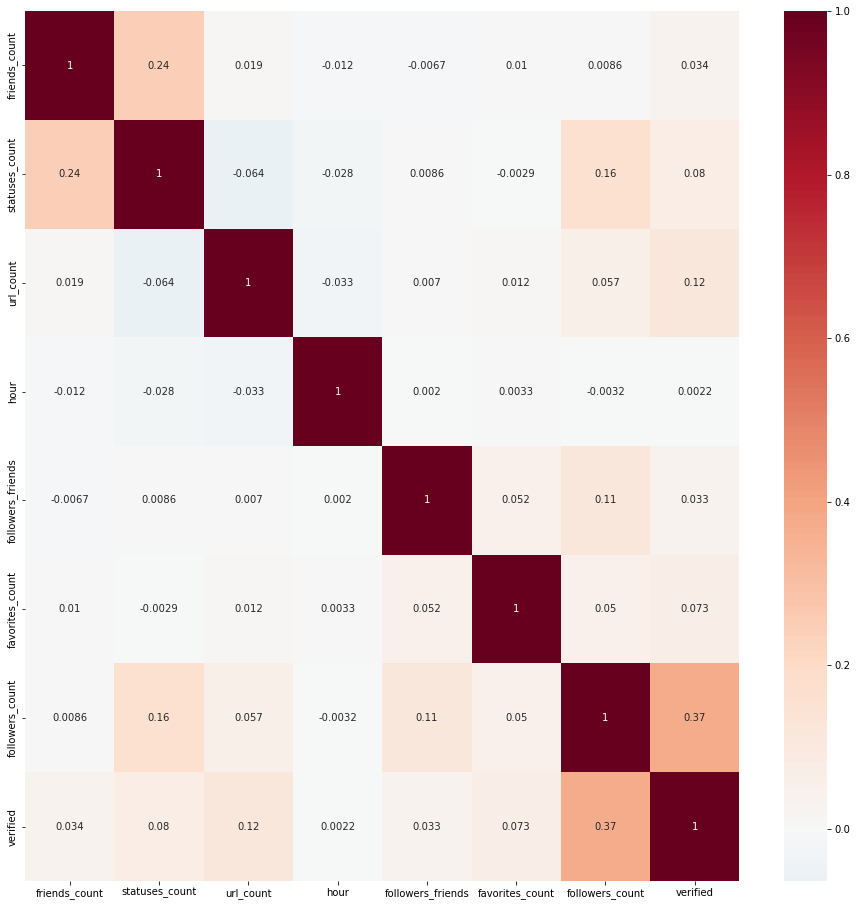

In [87]:
from scipy.cluster import hierarchy
%matplotlib inline
feature_importance = pd.DataFrame({'feature': new_X_train.drop(
    remove, axis=1).columns, 'importance': model.feature_importances_})
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance.sort_values(
    by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()


# plot correlation of features

order = np.array(hierarchy.dendrogram(
    hierarchy.ward(new_X_train.drop(remove, axis=1).corr()), no_plot=False)['ivl'], dtype="int")

rearranged_cov = new_X_train.drop(
    ['TweetID'], axis=1).corr().iloc[order, order]

plt.figure(figsize=(16, 16))

sns.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)


In [83]:
# plot model mse with number of top features
# TO DO
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest


### Models to consider
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))]))